## Goal: To forecast demand for each lat_long coordinate

### Initial data cleansing

In [4]:
import pandas as pd
import geohash as gh
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
plt.style.use('fivethirtyeight')
%matplotlib inline

In [5]:
import statistics as ss
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [6]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.


In [7]:
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [8]:
df = pd.read_csv('training.csv')

In [9]:
def get_hour(timestamp):
    if ":" not in timestamp[:2]:
        return timestamp[:2]
    else:
        return timestamp[:1]

In [10]:
def get_minute(timestamp):
    if ":" not in timestamp[-2:]:
        return timestamp[-2:]
    else:
        return timestamp[-1]

In [11]:
df['lat_long'] = df['geohash6'].apply(gh.decode_exactly)

In [12]:
df['x_coord'] = df['lat_long'].apply(lambda x: x[0])
df['y_coord'] = df['lat_long'].apply(lambda x: x[1])
df['hour'] = df['timestamp'].apply(get_hour)
df['minute'] = df['timestamp'].apply(get_minute)

In [13]:
convert_dtypes = {'x_coord': float, 'y_coord': float, 'day': int, 'hour': int, 'minute': int}
df = df.astype(convert_dtypes)

In [14]:
df['hour_min'] = df['hour']*4 + df['minute']/15
df = df.astype({'hour_min': int})

In [15]:
df['day_hour_min'] = (df['day']-1)*96 + df['hour_min']
df = df.astype({'day_hour_min': int})

In [16]:
def day_of_week(day):
    options = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    return options[day%7]

In [17]:
# Adding in the actual days of the week because we know there are differences in days of the 
# week (e.g. weekdays vs weekends)
df['day_of_week'] = df['day'].apply(day_of_week)

In [18]:
df.sort_values(by=['day', 'hour', 'minute'], inplace=True)

In [19]:
df.head()

,geohash6,day,timestamp,demand,lat_long,x_coord,y_coord,hour,minute,hour_min,day_hour_min,day_of_week
2289,qp09sx,1,0:0,0.021212,"(-5.32012939453125, 90.9063720703125, 0.002746...",-5.320129,90.906372,0,0,0,0,Tuesday
3149,qp0dhg,1,0:0,0.013217,"(-5.25421142578125, 90.9173583984375, 0.002746...",-5.254211,90.917358,0,0,0,0,Tuesday
11052,qp03x5,1,0:0,0.157956,"(-5.34210205078125, 90.6646728515625, 0.002746...",-5.342102,90.664673,0,0,0,0,Tuesday
23011,qp09bw,1,0:0,0.001262,"(-5.28167724609375, 90.7305908203125, 0.002746...",-5.281677,90.730591,0,0,0,0,Tuesday
26180,qp03wn,1,0:0,0.032721,"(-5.32562255859375, 90.6207275390625, 0.002746...",-5.325623,90.620728,0,0,0,0,Tuesday


### Simple visualisation to understand the data

In [174]:
df.head()

,geohash6,day,timestamp,demand,lat_long,x_coord,y_coord,hour,minute,hour_min,day_of_week,x_tfm,y_tfm,time_tfm,day_hour_min
2289,qp09sx,1,0:0,0.021212,"(-5.32012939453125, 90.9063720703125, 0.002746...",-5.320129,90.906372,0,0,0,Tuesday,0.666667,0.828571,0.0,0
3149,qp0dhg,1,0:0,0.013217,"(-5.25421142578125, 90.9173583984375, 0.002746...",-5.254211,90.917358,0,0,0,Tuesday,0.933333,0.857143,0.0,0
11052,qp03x5,1,0:0,0.157956,"(-5.34210205078125, 90.6646728515625, 0.002746...",-5.342102,90.664673,0,0,0,Tuesday,0.577778,0.200000,0.0,0
23011,qp09bw,1,0:0,0.001262,"(-5.28167724609375, 90.7305908203125, 0.002746...",-5.281677,90.730591,0,0,0,Tuesday,0.822222,0.371429,0.0,0
26180,qp03wn,1,0:0,0.032721,"(-5.32562255859375, 90.6207275390625, 0.002746...",-5.325623,90.620728,0,0,0,Tuesday,0.644444,0.085714,0.0,0


In [175]:
y = pd.pivot_table(df, values='geohash6', index=['day_hour_min'], aggfunc=np.count_nonzero)

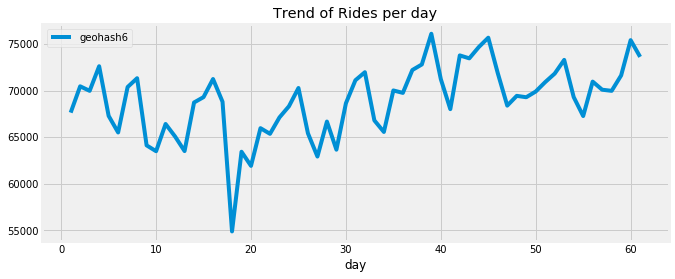

In [163]:
# plot does seem to show some seasonality 
y.plot(figsize=(10,4))
plt.title('Trend of Rides per day')
plt.show()

In [151]:
date_rng = pd.date_range(start='1/1/2018', end='3/02/2018', freq='d')

In [152]:
y.index = date_rng

In [185]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

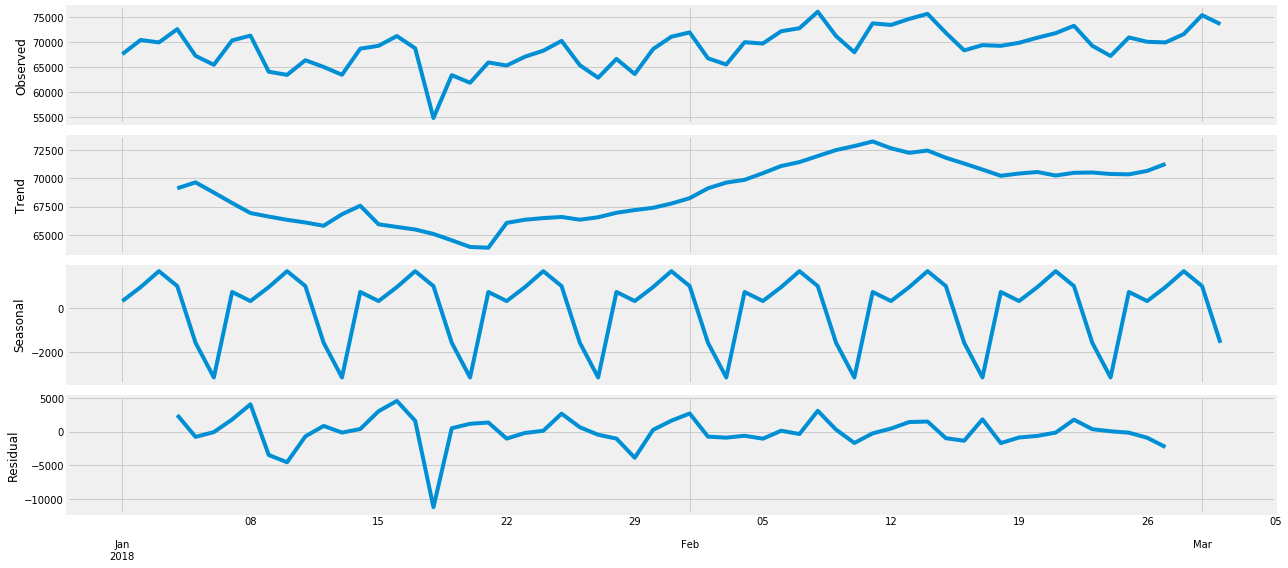

In [186]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

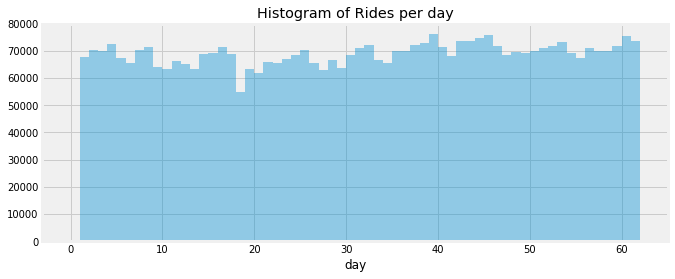

In [164]:
# data points per day evenly distributed
plt.figure(figsize=[10,4])
sns.distplot(df['day'], bins=[i for i in range(63)], kde=False)
plt.title('Histogram of Rides per day')
plt.show()

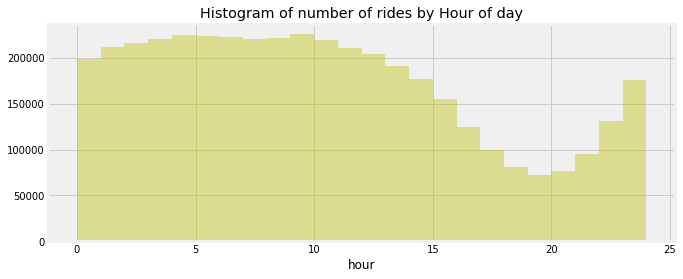

In [165]:
# most number of bookings come from 4am and 9am
plt.figure(figsize=[10,4])
sns.distplot(df['hour'], bins=[i for i in range(25)], kde=False, color='y')
plt.title('Histogram of number of rides by Hour of day')
plt.show()

### Scale the data

In [20]:
scalar = MinMaxScaler()

In [21]:
x_tfm = scalar.fit_transform(np.array(df['x_coord']).reshape(-1,1))
y_tfm = scalar.fit_transform(np.array(df['y_coord']).reshape(-1,1))

In [22]:
df['x_tfm'] = x_tfm
df['y_tfm'] = y_tfm

In [23]:
time_tfm = scalar.fit_transform(np.array(df['hour_min']).reshape(-1,1))

In [24]:
df['time_tfm'] = time_tfm

### Split data for training and testing

In [58]:
X = df[['x_tfm','y_tfm','time_tfm', 'day_of_week']]
y = df['demand']

In [59]:
labelencoder = LabelEncoder()
X.iloc[:, 3] = labelencoder.fit_transform(X.iloc[:, 3])

In [60]:
# One-hot encoding on day_of_week
onehotencoder = OneHotEncoder(categorical_features=[3])
X = onehotencoder.fit_transform(X).toarray()

In [61]:
X = pd.DataFrame(X)

In [62]:
split_ratio = 0.8
X_train = X.iloc[:int(round(split_ratio*len(df),0))]
X_test = X.iloc[int(round(split_ratio*len(df),0)):]
y_train = y.iloc[:int(round(split_ratio*len(df),0))]
y_test = y.iloc[int(round(split_ratio*len(df),0)):]

In [63]:
y_train = y_train.reset_index()
y_train = y_train['demand']
y_test = y_test.reset_index()
y_test = y_test['demand']

### Base Model - Linear Regression

In [31]:
model = LinearRegression()

In [32]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
y_pred = model.predict(X_test)

In [34]:
print("Baseline RMSE using Linear Regression:", round(np.sqrt(mean_squared_error(y_test, y_pred)),4))

Baseline RMSE using Linear Regression: 0.1692


### Secondary Models - Random Forest

In [37]:
# forest = RandomForestRegressor(n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features='auto',
#              max_depth=100, bootstrap=True)
forest = RandomForestRegressor(n_estimators=50)

In [38]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
y_pred_forest = forest.predict(X_test)

In [40]:
print('Random Forest RMSE: (50 trees)', np.sqrt(mean_squared_error(y_test, y_pred_forest)))

Random Forest RMSE: (50 trees) 0.05687657953092752


#### Using GridSearch to find optimal parameters for Random Forest

In [73]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [74]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [77]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [87]:
rf = RandomForestRegressor()

In [88]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [89]:
rf_random.fit(X_train[:10000], y_train[:10000])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [90]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

### Tertiary Models - Convolutional Neural Network, XGBoost

In [41]:
NN_model = Sequential()

In [42]:
# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________


In [43]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [44]:
NN_model.fit(X, y, epochs=1, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 3365056 samples, validate on 841265 samples
Epoch 1/1
3365056/3365056 [==============================] - 494s 147us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0135 - val_mean_squared_error: 0.0135

Epoch 00001: val_loss improved from inf to 0.01354, saving model to Weights-001--0.01354.hdf5


#### NN LSTM Models

In [45]:
from keras.layers import LSTM

In [46]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X)-look_back-1):
        a = X.iloc[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(y[i + look_back])
    return np.array(dataX), np.array(dataY)

In [47]:
look_back = 1
trainX, trainY = create_dataset(X_train, y_train, look_back)
testX, testY = create_dataset(X_test, y_test, look_back)

In [48]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [49]:
LSTM_model = Sequential()

In [50]:
LSTM_model.add(LSTM(32, input_shape=(look_back, 10)))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam')

In [51]:
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [2]:
# X_train = np.array(X_train)
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [52]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [69]:
# LSTM_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

In [53]:
LSTM_model2 = Sequential()
# LSTM_model2.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
LSTM_model2.add(LSTM(4, batch_input_shape=(1, look_back, 10), stateful=True, return_sequences=True))
LSTM_model2.add(LSTM(4, batch_input_shape=(1, look_back, 10), stateful=True))
LSTM_model2.add(Dense(1, activation='sigmoid'))
LSTM_model2.compile(loss='mean_squared_error', optimizer='adam')
for i in range(1):
    LSTM_model2.fit(trainX, trainY, epochs=1, batch_size=1, verbose=1, shuffle=False)
    LSTM_model2.reset_states()

Epoch 1/1
  50026/3365055 [..............................] - ETA: 3:01:57 - loss: 0.0236

KeyboardInterrupt: 

#### XGBoost

In [64]:
from xgboost import XGBRegressor

In [65]:
XGB_model = XGBRegressor(n_estimators=30, max_depth=20, objective='reg:squarederror')

In [66]:
XGB_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [67]:
XGB_pred = XGB_model.predict(X_test)

In [68]:
print('RMSE (XGB):', np.sqrt(mean_squared_error(y_test, XGB_pred)))

RMSE (XGB): 0.05761509963590325


In [128]:
# eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_metric = ["rmse"]
# %time XGB_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.384582	validation_1-rmse:0.381108
[1]	validation_0-rmse:0.347337	validation_1-rmse:0.343904
[2]	validation_0-rmse:0.314025	validation_1-rmse:0.310566
[3]	validation_0-rmse:0.284231	validation_1-rmse:0.280712
[4]	validation_0-rmse:0.257644	validation_1-rmse:0.254048
[5]	validation_0-rmse:0.233587	validation_1-rmse:0.230223
[6]	validation_0-rmse:0.212054	validation_1-rmse:0.209011
[7]	validation_0-rmse:0.192848	validation_1-rmse:0.190154
[8]	validation_0-rmse:0.175738	validation_1-rmse:0.173426
[9]	validation_0-rmse:0.160564	validation_1-rmse:0.158601
[10]	validation_0-rmse:0.147122	validation_1-rmse:0.145532
[11]	validation_0-rmse:0.13519	validation_1-rmse:0.13403
[12]	validation_0-rmse:0.124644	validation_1-rmse:0.123952
[13]	validation_0-rmse:0.115356	validation_1-rmse:0.115168
[14]	validation_0-rmse:0.107252	validation_1-rmse:0.107563
[15]	validation_0-rmse:0.100142	validation_1-rmse:0.100985
[16]	validation_0-rmse:0.094001	validation_1-rmse:0.095409
[17]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=5, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

**By 30 epochs**<p>
- Base case without other parameter tuning: 0.141472; 0.153465
- Max depth 5: 0.13688; 6: 0.127921; 7: 0.121879; 8: 0.110643; 9: 0.09821; 10: 0.089782; 12: 0.074021; 15: 0.067545; 18: 0.065445; 20: 0.065074 (anything more than 20 max depth has no effect)
- Gamma 0 is the best
- Alpha and lambda regularization did not prove useful (overfits at 0.065 rmse)

### Exploring Time Series models to see if the it makes any difference

In [189]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [192]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1181.1216566411538
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:729.683324430917
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:986.2477396244554
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:963.8483608414901
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:740.7083516865608
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:735.2529477211438
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1444.405364786815
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1144.8128186983754
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:937.1922953609612
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:697.0365439525679
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1188.1471326326262
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1141.822624099711
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:731.2074010907832
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:694.6381606160884
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:906.9858592436825


/Users/davidchong/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1438.6956937070577
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:927.5121700728475
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:908.0697600130727
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:712.2165158487204


/Users/davidchong/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1173.8958951483796
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1110.905422600012
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:883.6363492755731
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:924.4478207572856


/Users/davidchong/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1613.273138557039
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:923.0116320643483
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:885.4606312866349
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:716.4075244614743


/Users/davidchong/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1585.0203137519895
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1156.7683324569477
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:929.408848675868
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:952.5992556665981
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:711.1257714636039
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:929.4776129868051
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:930.729954345204
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:707.8592277822092
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:708.6764970260363
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1131.1732113956248
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:903.5602869245556
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:935.8223408642536
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:693.5931374221282
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:924.0550622253722
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:905.527011853884
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:706.8115708703896
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:691.2914456581711
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1134.9668141431196
ARIMA(1, 

/Users/davidchong/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1361.2067258302743
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:906.4200589929142
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:908.4113316302083
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:693.3783256605104


/Users/davidchong/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1364.0117259630392
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1111.109855607211
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:882.2107036066249
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:925.5900158768852
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1410.092221044395
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:900.326704361418
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:883.5192317792046
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:694.318478440561
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1300.1142345644098


/Users/davidchong/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [193]:
# Since SARIMAX(1,1,0)x(1,1,0,12) yields lowest AIC of 693.378 we shld use this as the optimal option
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1950      0.298     -0.656      0.512      -0.778       0.388
ar.S.L12      -0.5460      0.112     -4.895      0.000      -0.765      -0.327
sigma2      2.866e+07   2.99e-10    9.6e+16      0.000    2.87e+07    2.87e+07


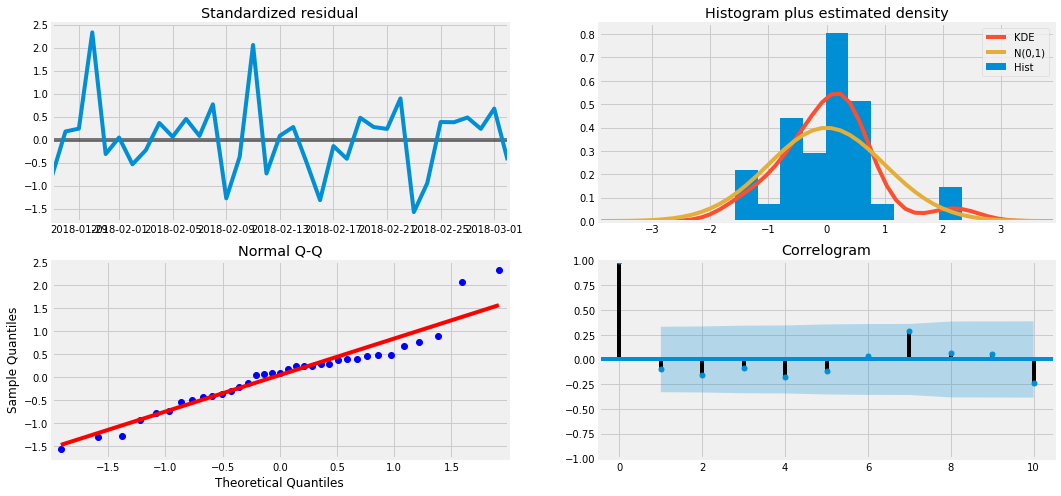

In [194]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

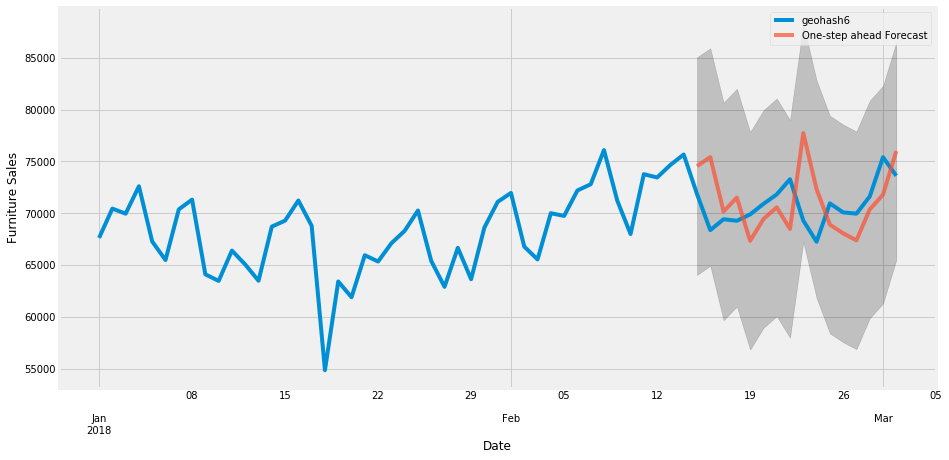

In [200]:
pred = results.get_prediction(start=pd.to_datetime('2018-02-15'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Since what we require is forecasting demand based on location, the above does not fit what we require as we are forecasting based on day and not location AND day. Let's do a pivot to see how demand per location changes over time.

In [217]:
z = pd.pivot_table(df[df['geohash6'] == 'qp03wc'], values='demand', index=df['timestamp'], aggfunc=np.sum)

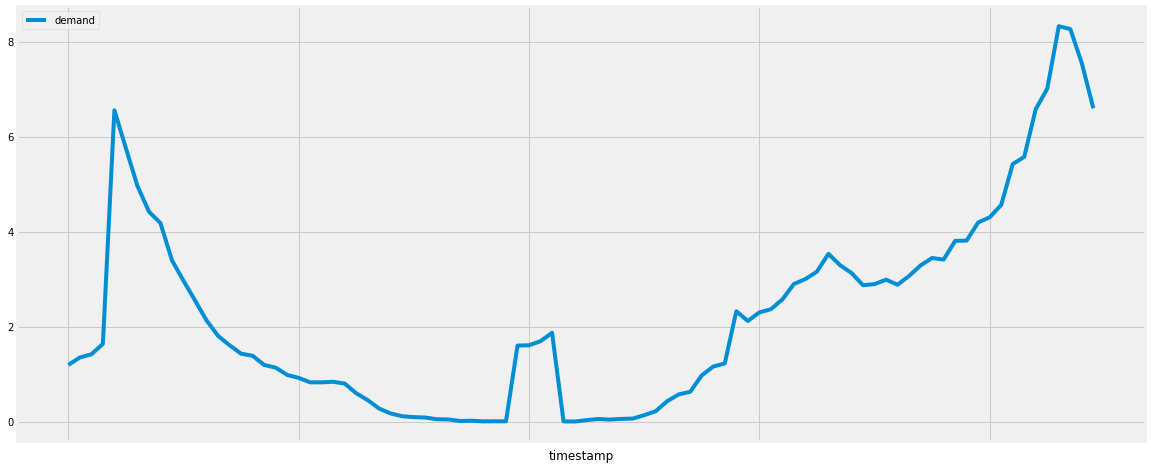

In [223]:
z.plot()
plt.show()